In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyreadr
import sklearn.linear_model as skl
import sklearn.model_selection as skm

In [2]:
train = pyreadr.read_r("masq_train.Rda")
test = pyreadr.read_r("masq_test.Rda")

train_df = train[None]
test_df = test[None]

### Question a

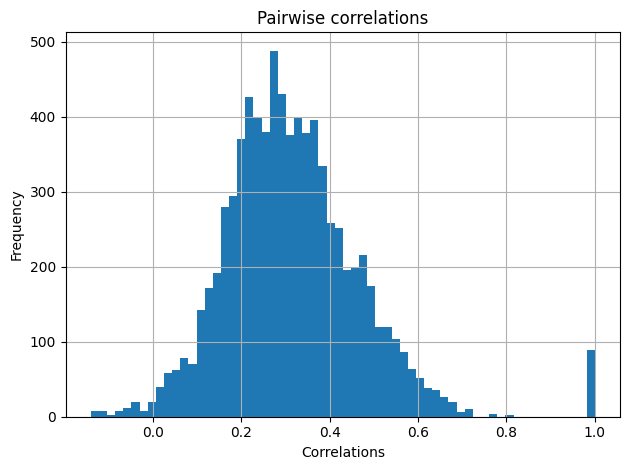

In [3]:
pairwise_corr = train_df[[x for x in train_df.columns if "MASQ" in x]].corr()
corrs = pairwise_corr.values.flatten()

fig, ax = plt.subplots()
ax.hist(corrs, bins='auto')
ax.set_xlabel("Correlations")
ax.set_ylabel("Frequency")
ax.set_title("Pairwise correlations")
ax.grid()
fig.tight_layout()

There is significant multicollinearity (excluding the diagonal of the correlation matrix), as the distribution of pairwise correlations is shifted to the right of $0$. Based on this multicollinearity, elastic net or ridge regression should be used in order to reduce the impacts of multicollinearity.

### Question b

Based on collinearity and the need for a sparser solution given the realistic context of diagnosis, the following models will be selected:
- Elastic net ($\alpha=0.5$)
- Ridge
- Lasso (not relaxed, as there is no well established implementation in Python for relaxed lasso unfortunately)

In [4]:
na_swapped_train_df = train_df.replace('NA', np.nan).dropna()
train_Y = na_swapped_train_df['D_DEPDYS']
train_X = na_swapped_train_df.iloc[:, 1:]
train_X['GENDER'] = train_X['GENDER'].apply(lambda x: 1 if x =="v" else 0)
train_X = train_X.astype(int)

In [5]:
validation = skm.KFold(10,
                       random_state=123,
                       shuffle=True)

# Elastic net with alpha=0.5
elastic_net_model = skl.LogisticRegression(l1_ratio=0.5,
                                           penalty='elasticnet',
                                           solver='saga',
                                           max_iter=10000)
elastic_net_results = skm.cross_validate(elastic_net_model,
                                         train_X,
                                         train_Y,
                                         scoring='accuracy',
                                         cv=validation)
elastic_net_result_accuracies = elastic_net_results['test_score']
average_elastic_net_accuracy = np.mean(elastic_net_result_accuracies)

# Ridge model
ridge_model = skl.LogisticRegression(penalty='l2',
                                     max_iter=10000)
ridge_results = skm.cross_validate(ridge_model,
                                   train_X,
                                   train_Y,
                                   scoring='accuracy',
                                   cv=validation)
ridge_result_accuracies = ridge_results['test_score']
average_ridge_accuracy = np.mean(ridge_result_accuracies)

# Lasso model
lasso_model = skl.LogisticRegression(penalty='l1',
                                     solver='saga',
                                     max_iter=10000)
lasso_results = skm.cross_validate(lasso_model,
                                   train_X,
                                   train_Y,
                                   scoring='accuracy',
                                   cv=validation)
lasso_result_accuracies = lasso_results['test_score']
average_lasso_accuracy = np.mean(lasso_result_accuracies)

Surprisingly, lasso logistic regression performs the best, with an accuracy of $0.738$

### Question d

In [ ]:
na_swapped_test_df = test_df.replace('NA', np.nan).dropna()
test_Y = na_swapped_test_df['D_DEPDYS']
test_X = na_swapped_test_df.iloc[:, 1:]
test_X['GENDER'] = test_X['GENDER'].apply(lambda x: 1 if x =="v" else 0)
test_X = test_X.astype(int)

final_lasso_model = skl.LogisticRegression(penalty='l1',
                                           solver='saga',
                                           max_iter=10000)
fitted_final_lasso = final_lasso_model.fit(train_X,
                                           train_Y)
1 - fitted_final_lasso.score(test_X, test_Y)

0.2260183968462549

The final misclassification rate is $22.6\%$

### Question e

In [ ]:
fitted_coefficients = fitted_final_lasso.coef_[0]
enumerated_coefficients = list(enumerate(fitted_coefficients))
non_zero_coeffs = [x for x in enumerated_coefficients if x[1] != 0]
selected_coeff_titles = test_X.columns[[x[0] for x in non_zero_coeffs]]
masq_enums = [int(x[4:]) for x in selected_coeff_titles if "MASQ" in x]

In [ ]:
anhedonic_items = [1, 14, 18, 21, 23, 26, 27, 30, 33, 35, 36, 
                   39, 40, 44, 49, 53, 58, 66, 72, 78, 86, 89]
anxious_arousal_items = [3, 19, 25, 45, 48, 52, 55, 57, 61, 
                         67, 69, 73, 75, 79, 85, 87, 88]
general_distres_depression_items = [6, 8, 10, 13, 16, 22, 24, 
                                    42, 47, 56, 64, 74]
general_distress_anxiety_items = [2, 9, 12, 15, 20, 59, 63, 65, 77, 81, 82]
general_distress_mixed_items = [4, 5, 17, 29, 31, 34, 37, 50, 51, 70, 76, 80, 83, 84, 90]

anhedonic_count = sum([x in anhedonic_items for x in masq_enums])
anxious_arousal_count = sum([x in anxious_arousal_items for x in masq_enums])
general_distres_depression_count = sum([x in general_distres_depression_items for x in masq_enums])
general_distress_anxiety_count = sum([x in general_distress_anxiety_items for x in masq_enums])
general_distress_mixed_count = sum([x in general_distress_mixed_items for x in masq_enums])

The most items are selected from the Anhedonic Depression subscale.